ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **05Mar21**

# 08. Poisson 1D with Dirichlet-Robin Boundary Conditions
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)

1. [Linear Transfer, Normal Flux Boundary Condition Case (Robin)](#rbc)
 + [Strong Form of Problem Statement](#rbcstrong)
 + [Variational Form of Problem Statement](#rbcweak)
 + [Problem Setup](#rbcsetup)
  - [Input File](#rbcinput)
  - [Run App](#rbcrun)
  - [Quadratic Lagrange FEM Results](#rbcquadfemresults1)
---

## [Objectives](#toc)<a id="obj"></a>

 + Begin using [`MOOSE`](https://mooseframework.inl.gov) to practice solving ODE's. Therefore access to a working [`MOOSE`](https://mooseframework.inl.gov) installation is necessary. Additional local information on installation for your computer setting can be found [here](https://github.com/UML-Linux-Club/moose-info).
 + Introduce the Galerkin variational (weak) form of the Poisson 1D problem below.
 + Introduce the use of the Dirichlet-Robin boundary condition.
 + Use second order accurate finite element Lagrange basis functions to solve the problem numerically.
 + <span style="color:red">Some initial code is provided in the course repository but no full source code is given out. If you do not do a minimum of programing you will not learn basic aspects of this subject. Hands-on work during lectures will fill in this gap. If you do all the steps proposed in this notebook and attend the working lectures you will only have an initial knowledge of the subject.</span>

In [8]:
'''Plot function for FEM Solution'''

def plot_solution(df, 
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(1, figsize=(14, 5))

    ax1.plot(df['x'], df['u'],'r*-',label=basis_functions_type)

    ax1.set_xlabel(r'$x$ [cm]', fontsize=18)
    ax1.set_ylabel(r'$u_h(x)$ [g/cc]', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    #ax1.set_ylim(0,1)
    ax1.grid(True)

    if 'diffFluxU_x' in df.columns:
        # create a twin x axis to be shared
        ax2 = ax1.twinx()

        ax2.plot(df['x'], df['diffFluxU_x'],'*-', color='yellow', label=flux_basis_functions_type)

        ax2.set_ylabel(r"$q_h(x)$ [g/cm$^2$-s]", fontsize=16, color='yellow')
        ax2.tick_params(axis='y', labelcolor='yellow', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        #ax2.set_ylim(0,2)
        #ax2.grid(True)

    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

## [Linear Transfer Normal Flux Boundary Condition Case (Robin)](#toc)<a id="rbc"></a>

A linear transfer condition imposed on the normal flux is a model for relating the unknown variable $u$ to external conditions of transport. Here the simplest linear case is the boundary condition

\begin{equation*}
 q(b) := h\,(u - u_\infty)
\end{equation*}

where $h\ge 0$ is a *transport coefficient* and $u_\infty$ is a reference value away from the exit point that drives the flux. Therefore this condition of transfer drives the variable $u$ towards $u_\infty$ for sufficiently high $h$.

In the literature, this boundary condition is related to the **Robin boundary condition** which is given on the *normal derivative* (or normal gradient) of the unknown variable. This is not the same as the *normal* diffusion flux $q_n$ associated to $u$, but related.

### [Strong Form of Problem Statement](#toc)<a id="rbcstrong"></a>

Solve the Poisson model problem. Find $u:[a,b]\subset\Reals\rightarrow\Reals$ for $D > 0$ such that:

\begin{align*}
 -\bigl(-D\, u'\bigr)'(x) + S &= 0 \quad \forall \quad x\in [a,b], \\
 u(a) &= A, \\
 q_n(b) &=  h\,(u - u_\infty).
\end{align*}
   
Solve this problem analytically for the constants: diffusion coefficient, $D$, source, $S$, entry concentration, $A$, mass transfer coefficient, $h$, and driving force concentration, $u_\infty$. 

### [Variational Form of Problem Statement](#toc)<a id="rbcweak"></a>

The Galerkin weak formulation is as follows. Find $u \in H^1\!\bigl([a,b]\bigr)$ so that 

\begin{align*}
 \int\limits_a^b -D\, u'(x)\,v'(x)\,dx - h\,\bigl(u(b) - u_\infty\bigr)\,v(b) + \int\limits_a^b S\,v(x)\,dx  &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr), 
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\in\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty \bigr\}$ and 
$H^1_0\!\bigl([a,b]\bigr) := \bigl\{ v \mid v \in H^1\!\bigl([a,b]\bigr), v(a) = 0 \bigr\}$. This weak form is a modified Galerkin's weak form including the Neumann boundary condition.

### [Dirichlet-Robin Energy](#toc)<a id="rbcenergy"></a>

The associated energy that the variational form minimizes is the **mixed Dirichlet/Robin total energy**:

\begin{align*}
 \Phi[u] := \int\limits_a^b \,\frac{1}{2}q^2 - D\,S\,u(x) \,dx + D\,h\,\bigl(u(b)-u_\infty\bigr)\,u(b).
\end{align*}

This is very much the same as the Dirichlet-Neumann energy except that the boundary energy term depends on the unknown variable evaluated at the boundary.

### [Problem Setup](#toc)<a id="rbcsetup"></a>

The previously developed code in [Notebook 07](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/07-poisson-1d-neumann.ipynb), for the constant normal flux boundary condition case, remains usable here by design. The normal diffusion flux was programmed in the general linear form:

\begin{equation*}
 q_n(x) =  q_\text{bias} + h\,\bigl(u(x) - u_\infty\bigr),
\end{equation*}

where the constant $q_\text{bias}$, used for the previous example case with constant normal flux boundary condition, is now set to zero value. The other two parameters ($h$ and $u_\infty$) need to be prescribed as shown in the input block below.

#### [Input File](#toc)<a id="rbcinput"></a>

Using a previous `input.i` input file (edit with a text editor), the `exit` block was modified as follows:

```
[BCs]
  [entry]
    type = DirichletBC      # from MOOSE
    variable = u
    boundary = left
    value = 3.00000e+00
  []
  [exit]
    type = NormalFluxBC           # user coded
    variable = u
    boundary = right
    bias = 0.00000e+00            # user coded
    transferCoeff = 1.00000e-01   # user coded
    reference = 5.00000e+00       # user coded
  []
[]

```

Save the input file in the `.../engy5310p1/` directory.

#### [Run Application](#toc)<a id="rbcrun"></a>

1. Run app: in the same directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.i`

#### [Quadratic Lagrange FEM](#toc)<a id="rbcquadfemresults1"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + h = 0.1 cm/s
> + u_infinity = 5 g/cc
> + D = 0.1 cm^2/s
> + S = 5e-2 g/cc-s

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 1

In [9]:
'''Domain'''

x_a = 0
x_b = 25

x_length = x_b - x_a

In [10]:
'''Parameters and data'''

diff_coeff = 0.1
source_s = 5e-2
mass_transfer_coeff = 0.1
u_infinity = 5             # external reference value

u_a = 3
qn_b = 0 # no flux on the exit point

In [11]:
'''FEM Solution'''

n_felem = 2

order = 'second'

#n_plot_pts = 2*n_felem + 1
n_plot_pts = 10

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, u_left=u_a, 
                             transfer_coeff_right=mass_transfer_coeff, u_reference_right=u_infinity, 
                             diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
                             n_plot_pts=n_plot_pts,
                             compute_diffusion_flux=True)

In [12]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 19Apr21 13:13:25

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 5.00000e-02
u_left = 3.00000e+00
transfer_coeff_right = 1.00000e-01
u_reference_right = 5.00000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 2
    elem_type = edge3
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = ${replace u_left}
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC
  []
  [diffFluxU_x]
    order = FIRST
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quant

In [13]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Mon Apr 19 13:13:27 2021
Executable Timestamp:    Sat Apr 17 21:27:24 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 5
    Local:                 5
  Elems:                   
    Total:                 2
    Local:                 2
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                5
  Num Local DOFs:          5
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                8
  Num Local DOFs:          8
  Variables:    

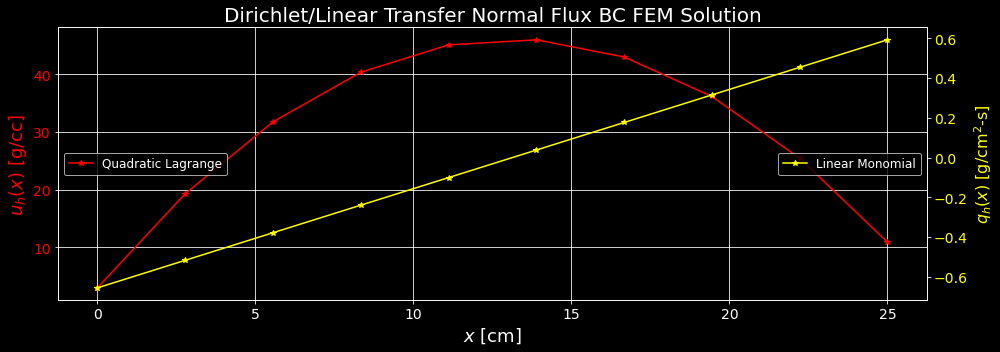

In [7]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')

plot_solution(df, title='Dirichlet/Linear Transfer Normal Flux BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')